<a href="https://www.kaggle.com/code/davewilliamsdata/u-s-states-ecology-explorer?scriptVersionId=133684752" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install adjustText
from adjustText import adjust_text

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas 

import re
import contextily as cx

from shapely.geometry import Point, Polygon, MultiPolygon, box

from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.text as mpltext
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerTuple, HandlerLine2D
from matplotlib.figure import Figure

from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important;} div.output_scroll { height: 1000px; }</style>"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
#state_name = input("Enter a U.S. State Name to explore: ")

In [4]:
us_states_gdb = geopandas.read_file('/kaggle/input/us-state-shapefiles/tl_2012_us_state/tl_2012_us_state.shp')

state_name = 'California'
us_states_gdb['centroid'] = us_states_gdb.centroid

us_states_gdb['center'] = list(zip(us_states_gdb.INTPTLAT.astype(float), us_states_gdb.INTPTLON.astype(float)))
state_row = us_states_gdb[us_states_gdb.NAME == state_name]

clipping_box = state_row.geometry.to_crs(epsg=4269)
state_center = state_row.center.values[0]
print(state_center)
print(clipping_box)

(37.1551773, -119.5434183)
55    MULTIPOLYGON (((-117.32095 32.68985, -117.3218...
Name: geometry, dtype: geometry


# USDA Forest Service Ecological Provinces

The USDA Forest Service provides a dataset of ecological provinces across the United States. These include geometries to plot the provinces on a map, and descriptions of each ecological province (vegetation, climate, etc). Here I read in the data, clipping it to records whose geometries (whole or part) are within that of the state of Colorado.

Utilizing the USDA Forest Service Geodata Clearinghouse at [https://data.fs.usda.gov/geodata/edw/datasets.php](http://) I gathered data, including geometries, for Ecological Provinces.

In [5]:
eco_provinces = geopandas.read_file("../input/usda-forest-service-eco-provinces/S_USA.EcoMapProvinces.gdb", mask=clipping_box)

#Examining the first few rows
eco_provinces.head(10)

MAP_TYPE MAP_LEVEL   PROJECT      DOMAIN_NAME                DIVISION_NAME  \
0     ECUN      PROV  ECOMAP07  Humid Temperate                       Marine   
1     ECUN      PROV  ECOMAP07              Dry             Temperate Desert   
2     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
3     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
4     ECUN      PROV  ECOMAP07              Dry             Temperate Desert   
5     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
6     ECUN      PROV  ECOMAP07              Dry  Tropical/Subtropical Desert   
7     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
8     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   

  MAP_UNIT_SYMBOL                                      MAP_UNIT_NAME  \
0            M242  Cascade Mixed Forest - Coniferous Forest - Alp...   
1             342                 Intermountain Semi-Desert Province   
2             263  California Coastal Steppe - Mixed Forest - Red...   
3            M261  Sierran Steppe - Mixed Forest - Coniferous For...   
4             341      Intermountain Semi-Desert and Desert Province   
5             262                     California Dry Steppe Province   
6             322           American Semi-Desert and Desert Province   
7             261  California Coastal Chaparral Forest and Shrub ...   
8            M262  California Coastal Range Open Woodland - Shrub...   

                                MAP_UNIT_DESCRIPTION  PROVINCE_  PROVINCE_ID  \
0  This ecoregion has some areas of mild maritime...          2            2   
1  This province has a semiarid, cold continental...         11           11   
2  In this province, the prevailing climate is ma...         14           14   
3  Winters are cold in this province. Precipitati...         15           15   
4  This province has a climate of hot summers and...         17           17   
5  The climate of this province consists of hot s...         20           20   
6  This province has a climate of long, hot summe...         22           22   
7  This province is characterized by a Mediterran...         24           24   
8  This province has a climate of hot, dry summer...         26           26   

  S_USA_EcoMapProvinces_AREA     PERIMETER         ACRES     GIS_ACRES  \
0                       None  6.897561e+06  3.486662e+07  3.486694e+07   
1                       None  1.338535e+07  1.016644e+08  1.016665e+08   
2                       None  1.721514e+06  4.046750e+06  4.046747e+06   
3                       None  5.443145e+06  4.300731e+07  4.300801e+07   
4                       None  8.818348e+06  7.185471e+07  7.185614e+07   
5                       None  2.673559e+06  1.208575e+07  1.208597e+07   
6                       None  4.958601e+06  5.975652e+07  5.975795e+07   
7                       None  3.356439e+06  6.789760e+06  6.789906e+06   
8                       None  3.180748e+06  1.294847e+07  1.294870e+07   

   GIS_MILES  SHAPE_Length  SHAPE_Area  \
0   4312.474     75.104539   16.337081   
1   8352.519    143.738047   45.727302   
2   1086.288     17.248952    1.717274   
3   3411.034     55.597054   18.343050   
4   5533.130     89.354727   30.336835   
5   1666.060     27.258560    4.971770   
6   3082.926     49.721014   23.751311   
7   2086.217     33.806260    2.724993   
8   1971.153     32.152328    5.173156   

                                            geometry  
0  MULTIPOLYGON (((-120.77659 43.64460, -120.7753...  
1  MULTIPOLYGON (((-120.17016 41.90622, -120.1711...  
2  MULTIPOLYGON (((-122.12962 38.28754, -122.1286...  
3  MULTIPOLYGON (((-119.80089 38.75223, -119.7928...  
4  MULTIPOLYGON (((-115.44968 38.33694, -115.4233...  
5  MULTIPOLYGON (((-119.96485 36.04245, -119.9713...  
6  MULTIPOLYGON (((-116.00702 33.70447, -116.0048...  
7  MULTIPOLYGON (((-118.71278 34.40122, -118.7108...  
8  MULTIPOLYGON (((-11

Inspecting columns.

In [6]:
eco_provinces.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   MAP_TYPE                    9 non-null      object  
 1   MAP_LEVEL                   9 non-null      object  
 2   PROJECT                     9 non-null      object  
 3   DOMAIN_NAME                 9 non-null      object  
 4   DIVISION_NAME               9 non-null      object  
 5   MAP_UNIT_SYMBOL             9 non-null      object  
 6   MAP_UNIT_NAME               9 non-null      object  
 7   MAP_UNIT_DESCRIPTION        9 non-null      object  
 8   PROVINCE_                   9 non-null      int64   
 9   PROVINCE_ID                 9 non-null      int64   
 10  S_USA_EcoMapProvinces_AREA  0 non-null      object  
 11  PERIMETER                   9 non-null      float64 
 12  ACRES                       9 non-null      float64 
 13  GIS_ACRES       

Dropping a column that contatins only null values, and verifying the change.

In [7]:
eco_provinces = eco_provinces.drop(columns=['S_USA_EcoMapProvinces_AREA'])
eco_provinces = eco_provinces[eco_provinces.MAP_UNIT_NAME != 'Water']
eco_provinces.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   MAP_TYPE              9 non-null      object  
 1   MAP_LEVEL             9 non-null      object  
 2   PROJECT               9 non-null      object  
 3   DOMAIN_NAME           9 non-null      object  
 4   DIVISION_NAME         9 non-null      object  
 5   MAP_UNIT_SYMBOL       9 non-null      object  
 6   MAP_UNIT_NAME         9 non-null      object  
 7   MAP_UNIT_DESCRIPTION  9 non-null      object  
 8   PROVINCE_             9 non-null      int64   
 9   PROVINCE_ID           9 non-null      int64   
 10  PERIMETER             9 non-null      float64 
 11  ACRES                 9 non-null      float64 
 12  GIS_ACRES             9 non-null      float64 
 13  GIS_MILES             9 non-null      float64 
 14  SHAPE_Length          9 non-null      float64 
 15  SH

The descriptions of the Eco Provinces as described in the data:

#  Coordinate Reference System

Geodataframes are similar to a tabular dataframe with the added feature of a geometry. This geometry feature is comprised of coordinates (one to create a point, many to create a shape.) These coordinates need to be in the same Coordinate Reference System as eachother for merging data, and aligned with the map tiles to be plotted and visualized. Here I examine the CRS, convert it, and plot the data on a map of the United States.

In [8]:
#Examining the crs attribute of the ecological provinces
print(eco_provinces.crs)

epsg:4269


In [9]:
#Converting the crs of the GeoDataFrame to EPSG:3857 to align with the map tiles

eco_provinces = eco_provinces.to_crs(epsg=3857)
eco_provinces.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
num_provs = eco_provinces.shape[0]

color_range = cm.tab20c(range(num_provs))
eco_provs = eco_provinces.MAP_UNIT_NAME.unique()
eco_colors = [(r,g,b) for r, g, b, a in [color for color in color_range]]
color_dict = dict(zip(eco_provs, eco_colors))
eco_cmap = ListedColormap(eco_colors)
print(color_dict)

{'Cascade Mixed Forest - Coniferous Forest - Alpine Meadow Province': (0.19215686274509805, 0.5098039215686274, 0.7411764705882353), 'Intermountain Semi-Desert Province': (0.4196078431372549, 0.6823529411764706, 0.8392156862745098), 'California Coastal Steppe - Mixed Forest - Redwood Forest Province': (0.6196078431372549, 0.792156862745098, 0.8823529411764706), 'Sierran Steppe - Mixed Forest - Coniferous Forest - Alpine Meadow Province': (0.7764705882352941, 0.8588235294117647, 0.9372549019607843), 'Intermountain Semi-Desert and Desert Province': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744), 'California Dry Steppe Province': (0.9921568627450981, 0.5529411764705883, 0.23529411764705882), 'American Semi-Desert and Desert Province': (0.9921568627450981, 0.6823529411764706, 0.4196078431372549), 'California Coastal Chaparral Forest and Shrub Province': (0.9921568627450981, 0.8156862745098039, 0.6352941176470588), 'California Coastal Range Open Woodland - Shrub - Coniferous

In [11]:
# Concatenating series to create a feature in df of formatted legend label data
eco_provinces['LEG_LABELS'] = eco_provinces['PROVINCE_ID'].map(str).str.cat(eco_provinces['MAP_UNIT_NAME'], sep=" ")
print(eco_provinces['LEG_LABELS'])
eco_provinces['colors'] = eco_colors
print(eco_provinces['colors'])

0    2 Cascade Mixed Forest - Coniferous Forest - A...
1                11 Intermountain Semi-Desert Province
2    14 California Coastal Steppe - Mixed Forest - ...
3    15 Sierran Steppe - Mixed Forest - Coniferous ...
4     17 Intermountain Semi-Desert and Desert Province
5                    20 California Dry Steppe Province
6          22 American Semi-Desert and Desert Province
7    24 California Coastal Chaparral Forest and Shr...
8    26 California Coastal Range Open Woodland - Sh...
Name: LEG_LABELS, dtype: object
0    (0.19215686274509805, 0.5098039215686274, 0.74...
1    (0.4196078431372549, 0.6823529411764706, 0.839...
2    (0.6196078431372549, 0.792156862745098, 0.8823...
3    (0.7764705882352941, 0.8588235294117647, 0.937...
4    (0.9019607843137255, 0.3333333333333333, 0.050...
5    (0.9921568627450981, 0.5529411764705883, 0.235...
6    (0.9921568627450981, 0.6823529411764706, 0.419...
7    (0.9921568627450981, 0.8156862745098039, 0.635...
8    (0.19215686274509805, 0.6392

In [12]:
polygon_lists = [list(multipol.geoms) for multipol in eco_provinces.geometry]

polygon_lists

#centroids = [polygon.centroid for polygon in plist for plist in [list(multipol.geoms) for multipol in eco_provinces.geometry]]

centroids = []
for plist in polygon_lists:
    num_polygons = len(plist)
    if num_polygons > 3:
        ctr = MultiPolygon(plist).representative_point()
        #if ctr.buffer(50).contains()
        centroids.append(ctr)

    else:
        for polygon in plist:
            centroids.append(polygon.representative_point())
centroids

In [13]:
centroid_gdf = geopandas.GeoDataFrame(data=centroids)
centroid_gdf = centroid_gdf.set_geometry(col=centroid_gdf[0])
centroid_gdf = centroid_gdf.set_crs(crs=eco_provinces.crs)
#centroid_gdf.within(eco_provinces.geometry[0])

centroids_gdf = centroid_gdf.sjoin(eco_provinces)
    
centroids_gdf.head(20)

0  \
0    POINT (-13559829.422009535 5723855.117716437)   
1    POINT (-13094173.130867936 5539875.355691547)   
2     POINT (-11998566.820396118 5278469.40920235)   
3    POINT (-13762730.713125505 4799424.045692187)   
4     POINT (-13805444.227057012 5100234.94883933)   
5   POINT (-13688937.472873865 4612548.9230366405)   
6    POINT (-13426611.908591397 4778346.735703956)   
7    POINT (-13227696.271151152 4732697.157761975)   
8    POINT (-12200084.964301117 4662068.244767915)   
9    POINT (-12196670.341415731 4882743.733072303)   
10    POINT (-13463112.34698491 4525829.697863603)   
11   POINT (-12853842.277753893 4095800.288659758)   
12   POINT (-13437045.644925853 4210674.877564887)   
13   POINT (-13369795.974654522 4202517.214549009)   

                             geometry  index_right MAP_TYPE MAP_LEVEL  \
0   POINT (-13559829.422 5723855.118)            0     ECUN      PROV   
1   POINT (-13094173.131 5539875.356)            1     ECUN      PROV   
2   POINT (-11998566.820 5278469.409)            1     ECUN      PROV   
3   POINT (-13762730.713 4799424.046)            2     ECUN      PROV   
4   POINT (-13805444.227 5100234.949)            2     ECUN      PROV   
5   POINT (-13688937.473 4612548.923)            2     ECUN      PROV   
6   POINT (-13426611.909 4778346.736)            3     ECUN      PROV   
7   POINT (-13227696.271 4732697.158)            4     ECUN      PROV   
8   POINT (-12200084.964 4662068.245)            4     ECUN      PROV   
9   POINT (-12196670.341 4882743.733)            4     ECUN      PROV   
10  POINT (-13463112.347 4525829.698)            5     ECUN      PROV   
11  POINT (-12853842.278 4095800.289)            6     ECUN      PROV   
12  POINT (-13437045.645 4210674.878)            7     ECUN      PROV   
13  POINT (-13369795.975 4202517.215)            8     ECUN      PROV   

     PROJECT      DOMAIN_NAME                DIVISION_NAME MAP_UNIT_SYMBOL  \
0   ECOMAP07  Humid Temperate                       Marine            M242   
1   ECOMAP07              Dry             Temperate Desert             342   
2   ECOMAP07              Dry             Temperate Desert             342   
3   ECOMAP07  Humid Temperate                Mediterranean             263   
4   ECOMAP07  Humid Temperate                Mediterranean             263   
5   ECOMAP07  Humid Temperate                Mediterranean             263   
6   ECOMAP07  Humid Temperate                Mediterranean            M261   
7   ECOMAP07              Dry             Temperate Desert             341   
8   ECOMAP07              Dry             Temperate Desert             341   
9   ECOMAP07              Dry             Temperate Desert             341   
10  ECOMAP07  Humid Temperate                Mediterranean             262   
11  ECOMAP07              Dry  Tropical/Subtropical Desert             322   
12  ECOMAP07  Humid Temperate                Mediterranean             261   
13  ECOMAP07  Humid Temperate                Mediterranean            M262   

                                        MAP_UNIT_NAME  ... PROVINCE_  \
0   Cascade Mixed Forest - Coniferous Forest - Alp...  ...         2   
1                  Intermountain Semi-Desert Province  ...        11   
2                  Intermountain Semi-Desert Province  ...        11   
3   California Coastal Steppe - Mixed Forest - Red...  ...        14   
4   California Coastal Steppe - Mixed Forest - Red...  ...        14   
5   California Coastal Steppe - Mixed Forest - Red...  ...        14   
6   Sierran Steppe - Mixed Forest - Coniferous For...  ...        15   
7       Intermountain Semi-Desert and Desert Province  ...        17   
8       Intermountain Semi-Desert and Desert Province  ...        17   
9       Intermountain Semi-Desert and Desert Province  ...        17   
10                     California Dry Steppe Province  ...        20   
11           American Semi-Desert and Desert Province  ...        22   
12  California Coastal Chaparral Fo

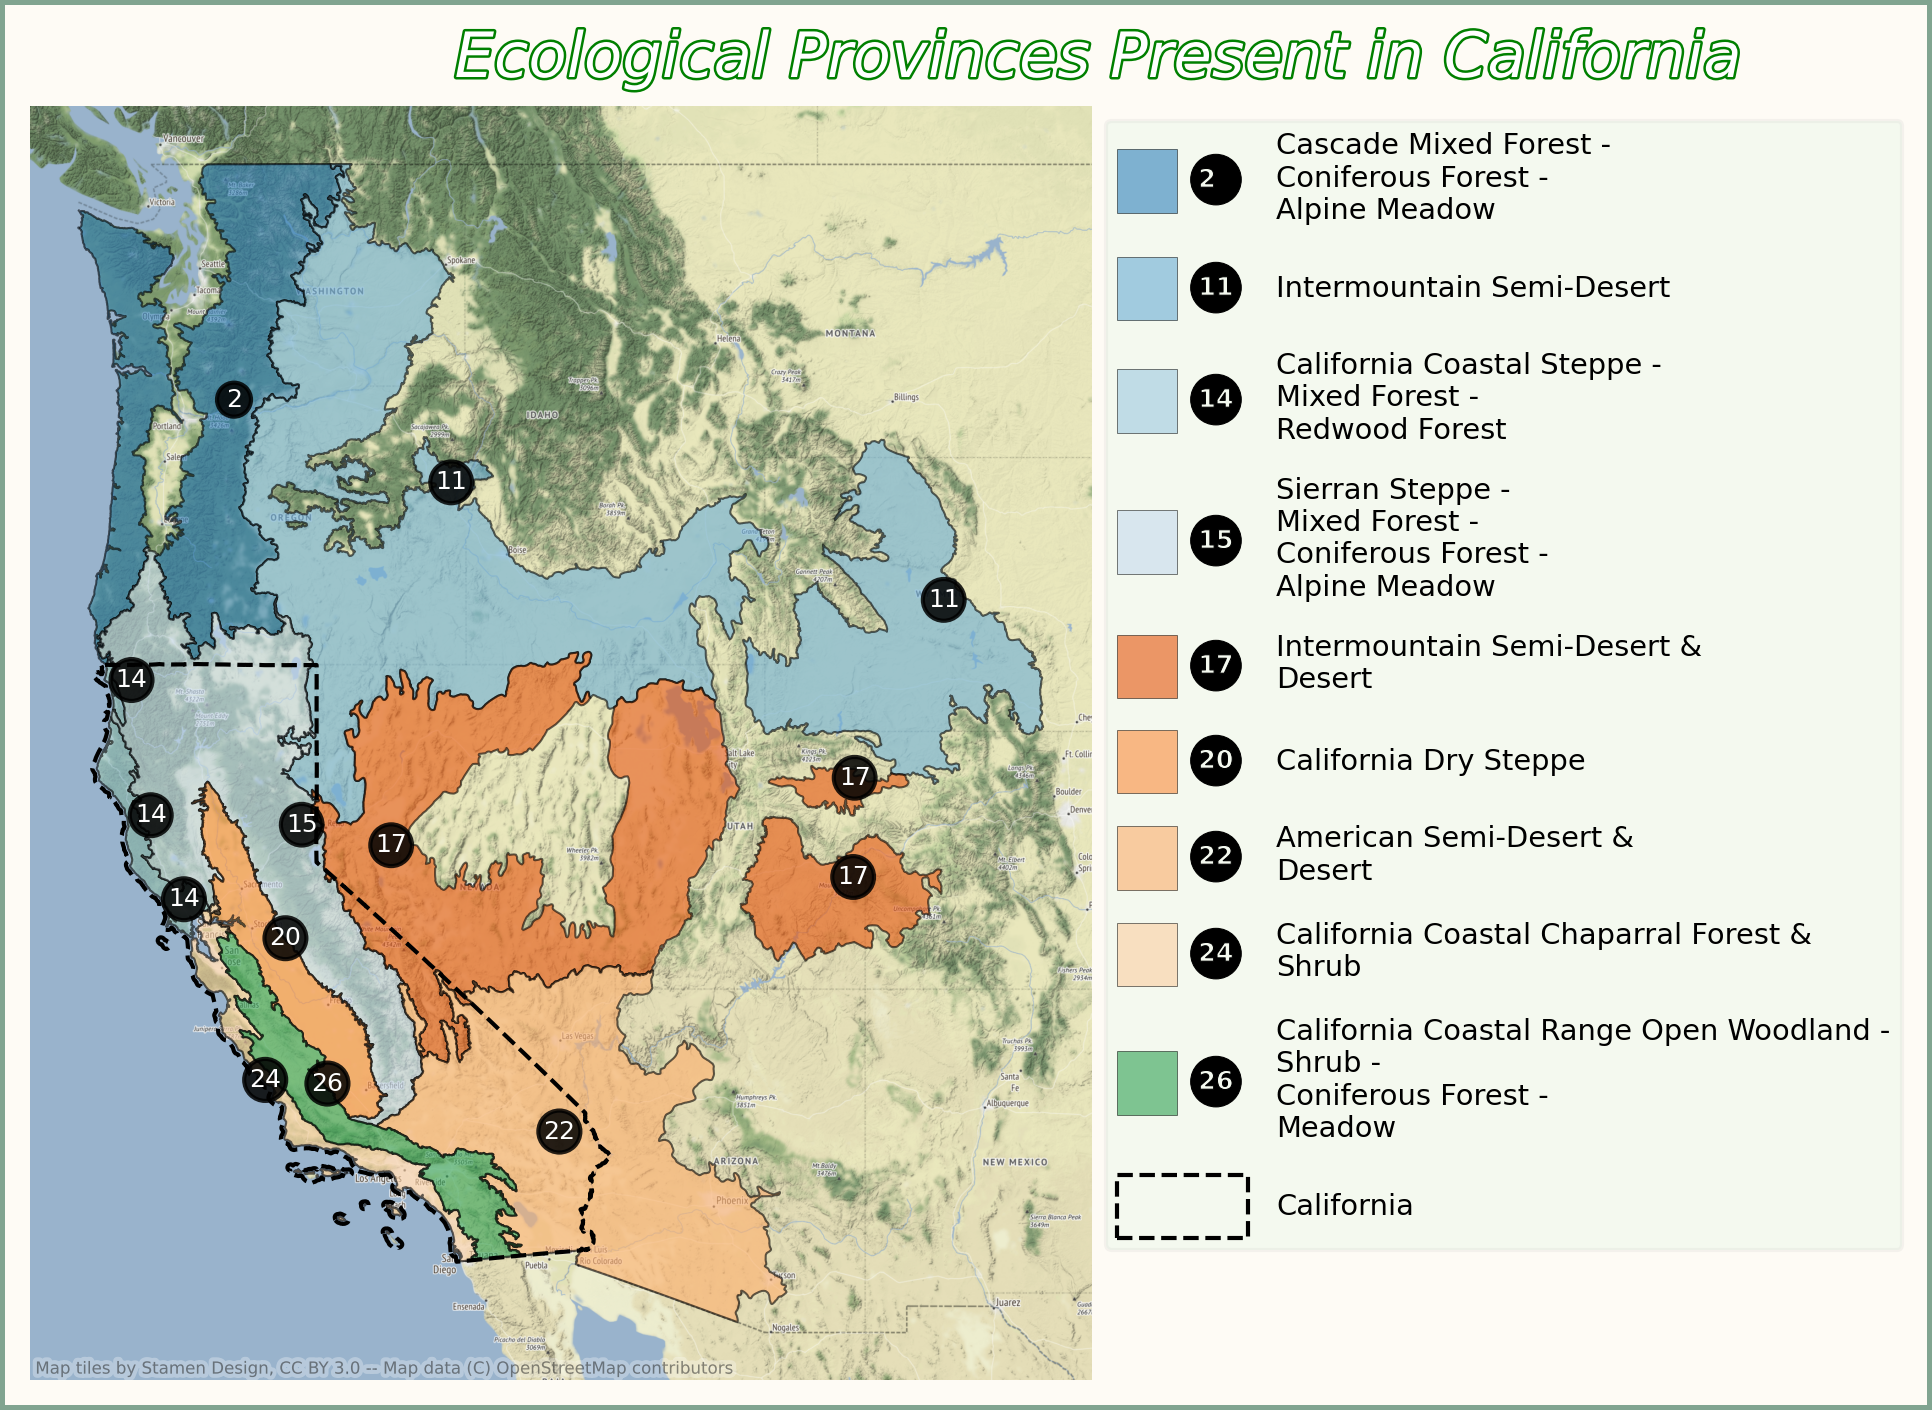

In [14]:

fig, ax = plt.subplots(layout='tight', edgecolor=(0.3, 0.5, 0.4, 0.7), linewidth=2)


eco_provinces.plot(ax = ax, color=eco_provinces['colors'], legend=True,legend_kwds={'loc':(0.0, 0.0),'shadow':True},alpha=0.6, edgecolor='black', linewidth=0.5, figsize=(5, 7),zorder=1)
cx.add_basemap(ax=ax, zoom=7)
ax.set_axis_off()
ax.set_title(label="Ecological Provinces Present in {}".format(state_name), fontstyle='oblique',color='white',path_effects=[pe.Stroke(linewidth=1.20, foreground='green'),pe.Normal()],fontsize=15,position=(0.4,1.3), va='baseline',pad=7, ha='left')

eco_provinces['CENTER'] = eco_provinces.geometry.representative_point()

centroids_gdf.apply(lambda x: ax.annotate(text=x['PROVINCE_ID'], bbox=dict(boxstyle='circle,pad=0.2',facecolor='black',alpha=0.85), xy=(x.geometry.x, x.geometry.y), color='white',  backgroundcolor=(0, 0, 0, 0.05),ha='center', va='center',fontsize=6), axis=1)

circle = mpath.Path.circle(center=(0,0), radius=100)

patches=[]
for color, i in zip(eco_colors, eco_provinces.PROVINCE_ID.unique()):
       
        number= mpltext.TextPath(xy=(-4,-3.5),s="{}".format(i), size=5,prop={'weight':'bold'})
        circle = mpath.Path.circle(center=(-0.50,-2.0), radius=5)
        
        marker = mpath.Path(vertices=np.concatenate([circle.vertices, number.vertices]),
                            codes=np.concatenate([circle.codes, number.codes]))
        
        color_patch = mpatches.Patch(facecolor = color, alpha=0.6, edgecolor='black',linewidth=0.2)

        line2 = Line2D([], [], ls='',color="#cef0d8", marker=marker, alpha=1,markerfacecolor='black', markeredgecolor='black',markersize=17, markeredgewidth=0.25)

        legend_tuple = tuple((color_patch, line2))
        patches.append(legend_tuple)

#patches = list(map(lambda x, y:(x, str(y)), patches, eco_provinces.PROVINCE_ID.unique()))

        
legend_labels = [re.sub('\d', '', re.sub('- ', '-\n', re.sub(' and ', ' &\n', re.sub(' Province', '', i)))).lstrip() for i in eco_provinces['LEG_LABELS']]



edge_color = [(0.6, 0, 0, 1)]
state_color = [(0.3, 0, 0, 0.0)]
us_states_gdb[us_states_gdb.NAME == state_name].plot(ax=ax, edgecolors='black', color=state_color, linestyle='--')
patches.append(mpatches.Patch(facecolor=(0.0,0.0,0.0, 0.0), edgecolor='black', linestyle='--', joinstyle='round'))
legend_labels.append(state_name)

plt.legend(handles=patches,labels=legend_labels, handler_map={tuple: HandlerTuple(ndivide=None)},handletextpad=1, bbox_to_anchor=(1, 1, 0, 0),loc='upper left', handleheight=3, handlelength=4.5, labelspacing=1.1, fontsize='x-small', facecolor='#cef0d8', framealpha=0.20)
ax.set_frame_on(True)


#fig.set_path_effects(path_effects=[pe.Normal(),pe.SimpleLineShadow(shadow_color='k'),])

fig.set_facecolor(((252 / 255), (244 / 255), (222/255), 0.3))

annotations = [child for child in ax.get_children() if isinstance(child, mpltext.Annotation)]
adjust_text(annotations, avoid_self=False)

ax.get_children()[2].set(fontsize=4, alpha=0.3)

plt.show()



Using a bbox when reading in the data includes all eco provinces that exist in the state, but these extend far outside the borders of the state, so here I cut the eco province polygons off at the edges of the state. I utilize a bounding box, which works if the data is in CRS epsg:4269, so I convert it before I cut the provinces at the border of the state.

In [15]:


eco_provinces_state = eco_provinces.to_crs(epsg=4269).clip(mask=clipping_box)
eco_provinces_state = eco_provinces_state.to_crs(epsg=3857)
polygon_lists_state = [list(province.geoms) if province.type == 'MultiPolygon' else province for province in eco_provinces_state.geometry ]


state_centroids = []

for province in eco_provinces_state.geometry:
    if province.type == 'Polygon':
        state_centroids.append(province.representative_point())
    elif (province.type == 'MultiPolygon') & (len(province.geoms) > 3):
            ctr = province.representative_point()
            state_centroids.append(ctr)
    else:
        for p in province.geoms:
            state_centroids.append(p.representative_point())
            


In [16]:
patches.pop()
legend_labels.pop()

'California'

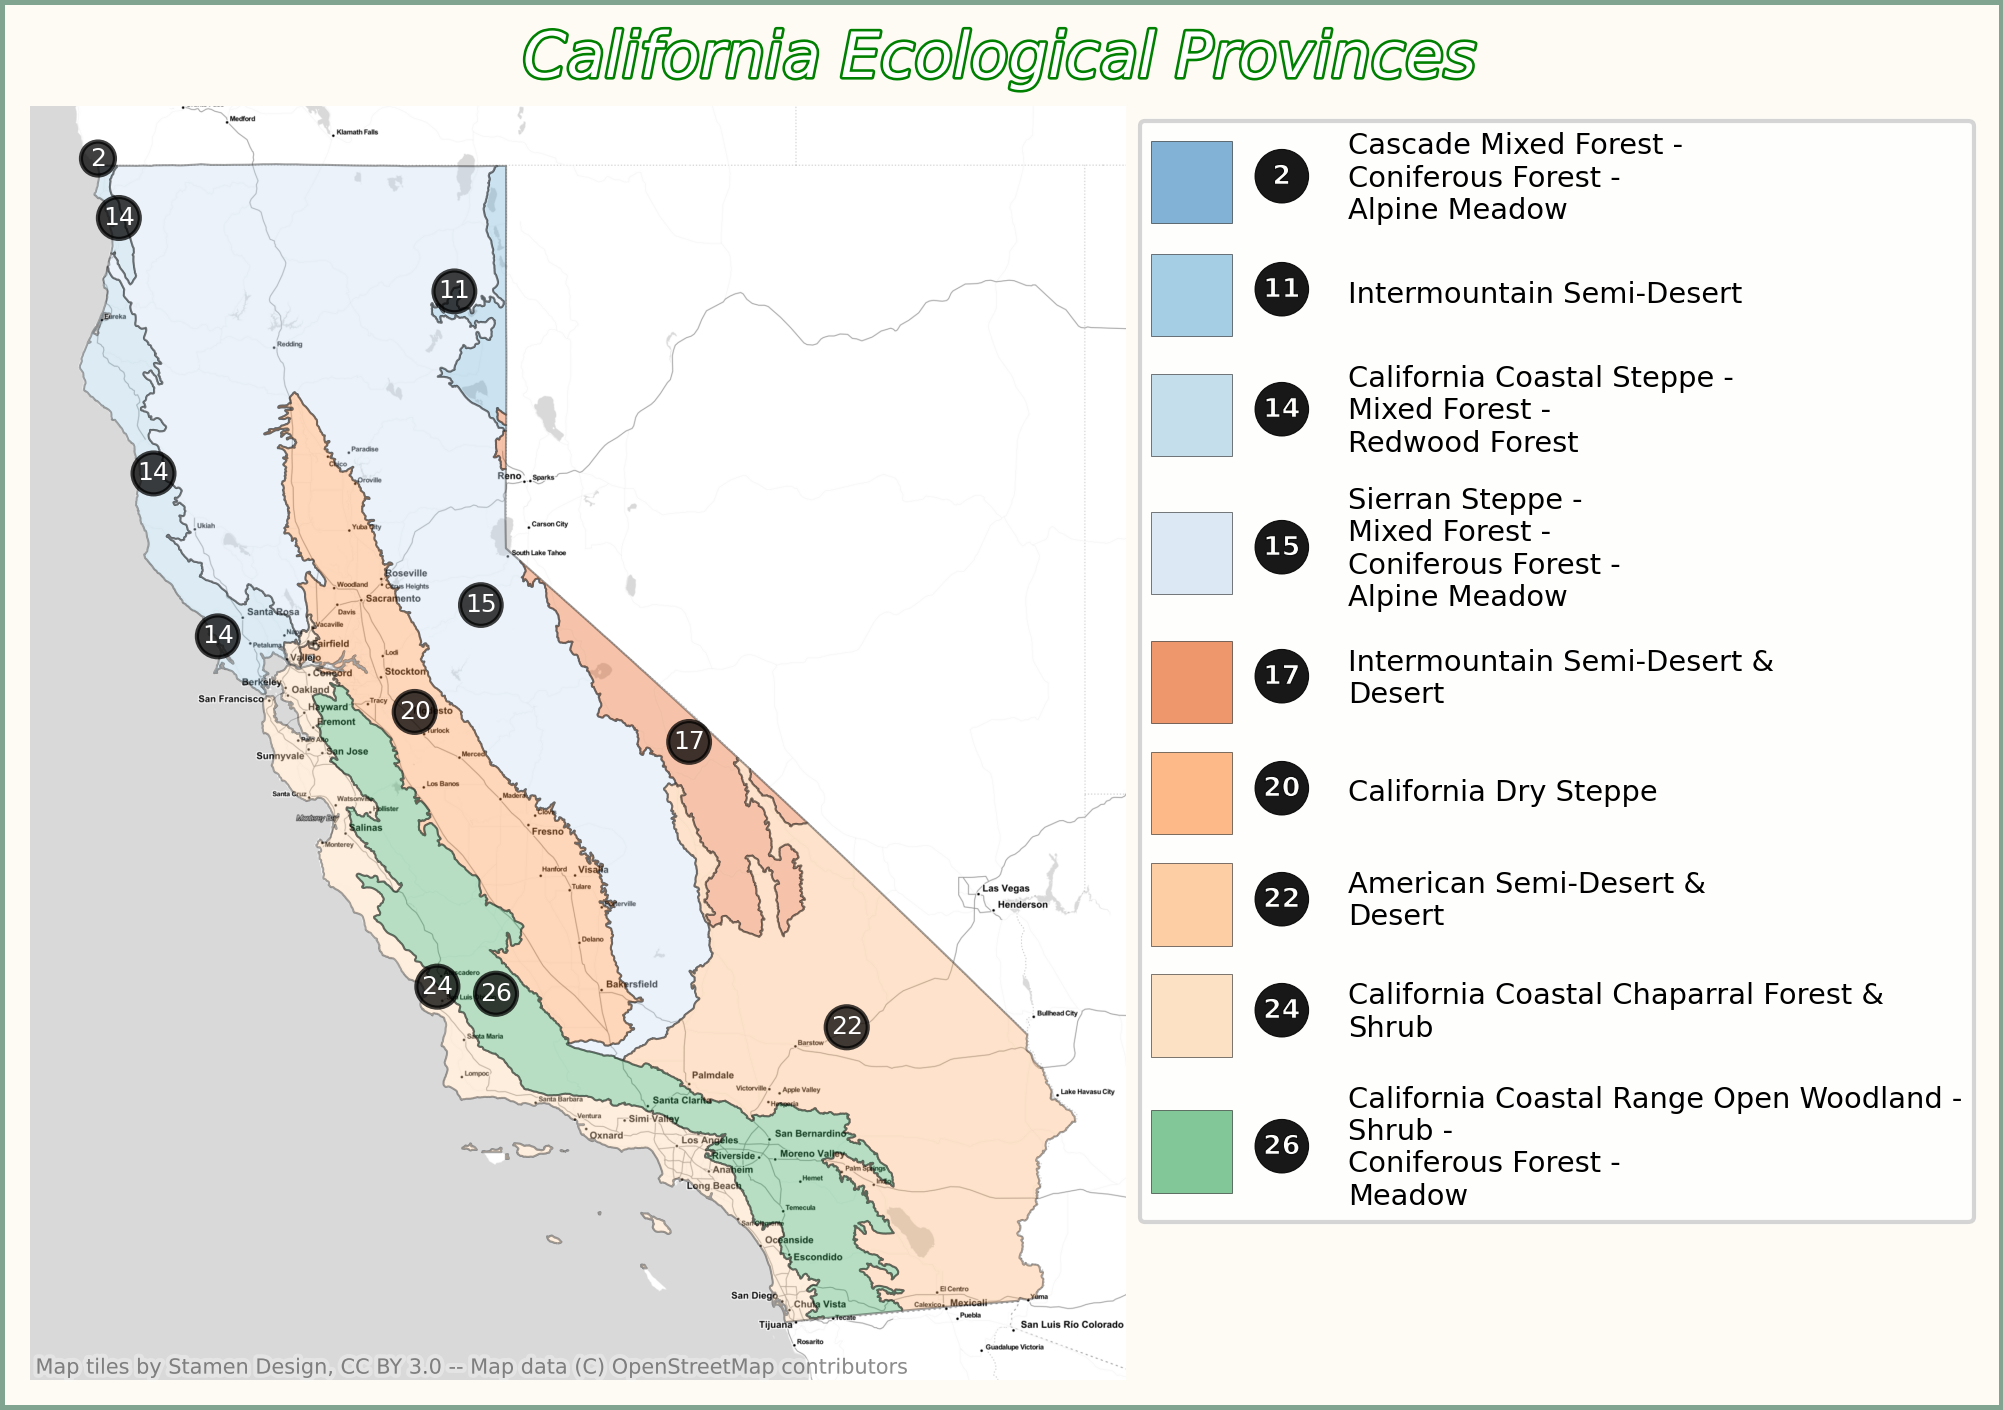

In [17]:

fig, ax = plt.subplots(layout='tight', edgecolor=(0.3, 0.5, 0.4, 0.7), linewidth=2)

eco_provinces_state = eco_provinces_state.sort_values('PROVINCE_ID')

# Plotting the data on matplotlib ax
eco_provinces_state.plot(ax = ax ,color=eco_provinces_state['colors'],legend=True,cmap=eco_cmap,legend_kwds={'loc':(1, 1),'shadow':True},alpha=0.35, linewidth=0.5, edgecolor='black', figsize=(7,7))
cx.add_basemap(ax, zoom=8, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()
ax.set_title('{} Ecological Provinces'.format(state_name), position=(0.45, 0.75), fontstyle='oblique',color='white',path_effects=[pe.Stroke(linewidth=1.25, foreground='green'),pe.Normal()],fontsize=15, va='baseline',pad=7, ha='left')

patches=[]

for color, i in zip(eco_colors,eco_provinces.PROVINCE_ID.unique()):
    
    if len(str(i)) < 2:
        i = " {}".format(i)
    else:
        i=i
        #number = mpltext.TextPath(xy=(-0.70,-0.57), s="{}".format(i), size=1)
    number= mpltext.TextPath(xy=(-4,-3.5),s="{}".format(i), size=5,prop={'weight':'bold'})
    circle = mpath.Path.circle(center=(-0.50,-2.0), radius=5)
        
    marker = mpath.Path(vertices=np.concatenate([circle.vertices, number.vertices]),
                            codes=np.concatenate([circle.codes, number.codes]))
    
        
    color_patch = mpatches.Patch(facecolor = color, alpha=0.6, edgecolor='black',linewidth=0.2)
   
    line2 = Line2D([], [], ls='',color="black", marker=marker,alpha=0.9,markersize=18, markeredgewidth=0.25,antialiased=True)
   
    legend_tuple = tuple((color_patch, line2))
    patches.append(legend_tuple)


        
centroids_gdf = geopandas.GeoDataFrame(data=state_centroids)
centroids_gdf = centroids_gdf.set_geometry(col=centroids_gdf[0])
centroids_gdf = centroids_gdf.set_crs(crs=eco_provinces_state.crs)

centroids_gdf = centroids_gdf.sjoin(eco_provinces_state)
centroids_gdf.sort_values('PROVINCE_ID')

# Plotting the PROVINCE_ID values of df at center of provinces        
centroids_gdf.apply(lambda x: ax.annotate(text=x['PROVINCE_ID'], zorder=2,xy=(x.geometry.x, x.geometry.y), color='white',  bbox=dict(boxstyle='circle,pad=0.2',facecolor='black', alpha=0.75),ha='center', fontsize=6), axis=1)



ax.legend(handles=patches, labels=legend_labels, handler_map={tuple: HandlerTuple(ndivide=None)},bbox_to_anchor=(1, 1, 0, 0), loc='upper left', handleheight=4, handlelength=6,labelspacing=1, fontsize='x-small')
fig.set_facecolor(((252 / 255), (244 / 255), (222/255), 0.3))
ax.get_children()[2].set(fontsize=5, alpha=0.3)

fig.tight_layout()

plt.show()

In [18]:
eco_provinces_state

MAP_TYPE MAP_LEVEL   PROJECT      DOMAIN_NAME                DIVISION_NAME  \
0     ECUN      PROV  ECOMAP07  Humid Temperate                       Marine   
1     ECUN      PROV  ECOMAP07              Dry             Temperate Desert   
2     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
3     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
4     ECUN      PROV  ECOMAP07              Dry             Temperate Desert   
5     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
6     ECUN      PROV  ECOMAP07              Dry  Tropical/Subtropical Desert   
7     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   
8     ECUN      PROV  ECOMAP07  Humid Temperate                Mediterranean   

  MAP_UNIT_SYMBOL                                      MAP_UNIT_NAME  \
0            M242  Cascade Mixed Forest - Coniferous Forest - Alp...   
1             342                 Intermountain Semi-Desert Province   
2             263  California Coastal Steppe - Mixed Forest - Red...   
3            M261  Sierran Steppe - Mixed Forest - Coniferous For...   
4             341      Intermountain Semi-Desert and Desert Province   
5             262                     California Dry Steppe Province   
6             322           American Semi-Desert and Desert Province   
7             261  California Coastal Chaparral Forest and Shrub ...   
8            M262  California Coastal Range Open Woodland - Shrub...   

                                MAP_UNIT_DESCRIPTION  PROVINCE_  PROVINCE_ID  \
0  This ecoregion has some areas of mild maritime...          2            2   
1  This province has a semiarid, cold continental...         11           11   
2  In this province, the prevailing climate is ma...         14           14   
3  Winters are cold in this province. Precipitati...         15           15   
4  This province has a climate of hot summers and...         17           17   
5  The climate of this province consists of hot s...         20           20   
6  This province has a climate of long, hot summe...         22           22   
7  This province is characterized by a Mediterran...         24           24   
8  This province has a climate of hot, dry summer...         26           26   

      PERIMETER         ACRES     GIS_ACRES  GIS_MILES  SHAPE_Length  \
0  6.897561e+06  3.486662e+07  3.486694e+07   4312.474     75.104539   
1  1.338535e+07  1.016644e+08  1.016665e+08   8352.519    143.738047   
2  1.721514e+06  4.046750e+06  4.046747e+06   1086.288     17.248952   
3  5.443145e+06  4.300731e+07  4.300801e+07   3411.034     55.597054   
4  8.818348e+06  7.185471e+07  7.185614e+07   5533.130     89.354727   
5  2.673559e+06  1.208575e+07  1.208597e+07   1666.060     27.258560   
6  4.958601e+06  5.975652e+07  5.975795e+07   3082.926     49.721014   
7  3.356439e+06  6.789760e+06  6.789906e+06   2086.217     33.806260   
8  3.180748e+06  1.294847e+07  1.294870e+07   1971.153     32.152328   

   SHAPE_Area                                           geometry  \
0   16.337081  POLYGON ((-13826194.319 5160725.759, -13826554...   
1   45.727302  POLYGON ((-13377394.994 5146944.589, -13377616...   
2    1.717274  MULTIPOLYGON (((-13595296.773 4619394.950, -13...   
3   18.343050  POLYGON ((-13335275.169 4685458.043, -13334795...   
4   30.336835  MULTIPOLYGON (((-13013214.071 4406363.933, -13...   
5    4.971770  POLYGON ((-13355149.295 4306553.248, -13355790...   
6   23.751311  POLYGON ((-12913597.746 3990160.669, -12913650...   
7    2.724993  MULTIPOLYGON (((-13214831.504 4082186.720, -13...   
8    5.173156  POLYGON ((-13049632.737 4074645.047, -13049797...   

                                          LEG_LABELS  \
0  2 Cascade Mixed Forest - Coniferous Forest - A...   
1              11 Intermountain Semi-Desert Province   
2  14 California Coastal Steppe - Mixed Forest - ...   
3  15 Sierran Steppe - Mixed Forest - Coniferous ... 

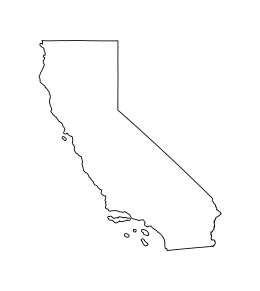

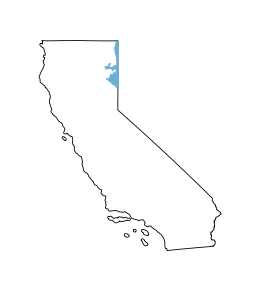

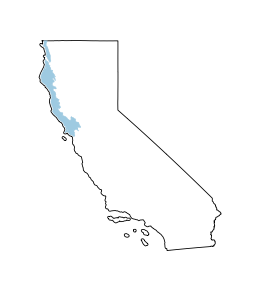

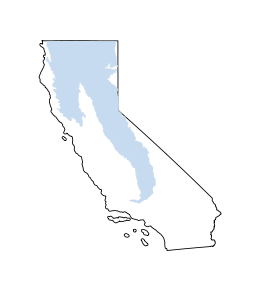

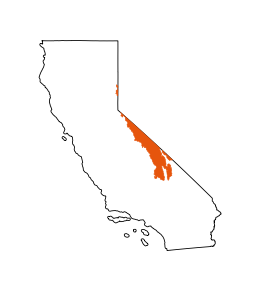

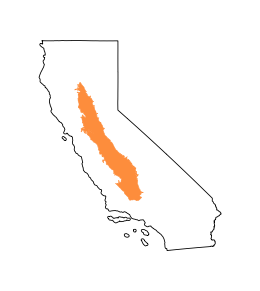

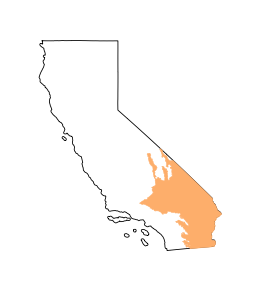

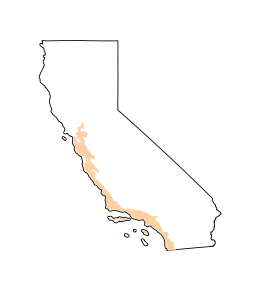

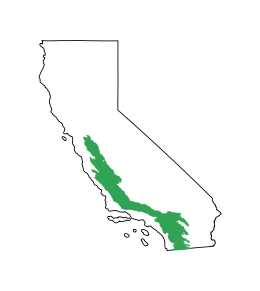

In [19]:
# crs sanity check
eco_provinces_state = geopandas.GeoDataFrame(eco_provinces_state, geometry='geometry', crs=centroids_gdf.crs)

# generating maps of each province within each state
for i in range(eco_provinces_state.shape[0]):
    fig, ax = plt.subplots(figsize=(1,1))
    us_states_gdb[us_states_gdb.NAME == state_name].plot( ax=ax,edgecolors='black', color=state_color, linestyle='-',zorder=1, linewidth=0.2)
    eco_provinces_state.loc[[i], 'geometry'].plot( ax=ax, zorder=2, color=eco_colors[i], linewidth=0.1, linestyle='-', edgecolor=eco_colors[i])
    ax.set_axis_off()
    fig.savefig('/kaggle/working/Eco-Province-{}.png'.format(i), dpi=500)
    


In [20]:
# HTML formatted Names and Descriptions of Eco Provinces
display(HTML("<h1 style='text-align:center;padding:5px;' >Ecological Provinces of {}</h1>".format(state_name)))

# Programmatically generating HTML for glossary
for i, row in eco_provinces.iterrows():
    prov_id = row.PROVINCE_ID
    name = row.MAP_UNIT_NAME
    desc = row.MAP_UNIT_DESCRIPTION
    
    string = """<div style="border:5px solid green;padding:15px;">
                    <h2>{}</h2>
                        <h3>Map ID: {}</h3> \n\n 
                        <div style="display:flex;margin:10px;">
                            <p style='font-size:120%;flex:1;'>{}</p>
                            <img style="flex:1;" src="Eco-Province-{}.png" alt="Eco Province ID {}">
                        </div>
                        <div style='background:powderblue;padding:2px;'></div> \n
                </div>""".format(name, prov_id, desc, i, prov_id)

    display(HTML(string))

display(HTML("<div style='background:green;padding:20px;'></div>"))